In [1]:
from pycbc.psd import analytical
from matplotlib import pyplot as plt
import numpy as np

/home/gareth/3g/env_3g/src/pycbc/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [2]:
psds_to_plot = [psd for psd in analytical.get_lalsim_psd_list() if 'instein' in psd or 'osmic' in psd]
psds_to_plot += ['aLIGOZeroDetHighPowerGWINC']

print(psds_to_plot)

psd_cutoffs = [1, 6, 1, 1, 10]

['CosmicExplorerP1600143', 'CosmicExplorerPessimisticP1600143', 'CosmicExplorerWidebandP1600143', 'EinsteinTelescopeP1600143', 'aLIGOZeroDetHighPowerGWINC']


Text(0, 0.5, 'PSD, Hz$^{-1}$')

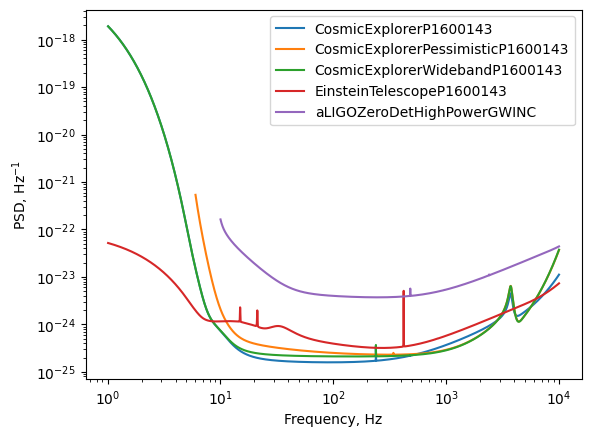

In [3]:
for psd, cutoff in zip(psds_to_plot, psd_cutoffs):
    flower = 5 if 'LIGO' in psd else 0.5
    psd_fs = analytical.from_string(psd, 1000000, 0.01, flower)
    nz = np.logical_and(abs(psd_fs) > 0, psd_fs.sample_frequencies > cutoff)
    plt.plot(psd_fs.sample_frequencies[nz], np.sqrt(abs(psd_fs[nz])), label=psd)

plt.loglog()
plt.legend()
plt.xlabel('Frequency, Hz')
plt.ylabel('PSD, Hz$^{-1}$')